# Initialization

In [376]:
import numpy as np

SEED = 42
NUM_ELEMENTS = 100000  # 100k elements in the stream
NUM_UNIQUE = 10000  # 10k unique elements
NUM_RUNS = 25

# Set the seed for reproducibility
np.random.seed(SEED)

# Generate a stream of elements
stream = np.random.randint(0, NUM_UNIQUE, NUM_ELEMENTS)

# Shuffle the stream
np.random.shuffle(stream)

print(f"Stream length: {len(stream)}")
print(f"Number of unique elements: {len(np.unique(stream))}")
print(f"First 10 elements of the stream: {stream[:10]}")

# Generate sketches
sketch_sizes = np.logspace(1, 5, num=30, base=10, dtype=int)
print(f"Sketch sizes: {sketch_sizes}")


Stream length: 100000
Number of unique elements: 10000
First 10 elements of the stream: [7373 4170 6775 6174 3168 6847 9084 1929 1287 1598]
Sketch sizes: [    10     13     18     25     35     48     67     92    126    174
    239    329    452    621    853   1172   1610   2212   3039   4175
   5736   7880  10826  14873  20433  28072  38566  52983  72789 100000]


In [377]:
import hashlib

def hash_fn(element, seed=SEED):
    """
    Hash function that maps an element to a random number between 0 and 1.
    """
    hash_obj = hashlib.sha256(f"{seed}-{element}".encode())
    hash_int = int(hash_obj.hexdigest(), 16)
    return hash_int / 2**256

## Flajolet Martin

### Flajolet Martin - Alpha Version

In [388]:
def flajolet_martin(stream: np.ndarray) -> float:
    """
    Flajolet-Martin algorithm for counting distinct elements in a stream.
    :param stream: numpy array of elements
    :return: estimated number of distinct elements
    """
    X = 1  # Initialize the maximum possible hash value
    for element in stream:
        X = min(X, hash_fn(element))
    return 1 / X

### Flajolet Martin - Beta Version

In [389]:
from concurrent.futures import ThreadPoolExecutor
from typing import Optional

def chunk_stream(stream: np.ndarray, chunk_size: int) -> np.ndarray:
    """
    Split the stream into chunks of a given size.
    :param stream: numpy array of elements
    :param chunk_size: size of the chunks
    :return: list of numpy arrays
    """
    return [stream[i:i + chunk_size] for i in range(0, len(stream), chunk_size)]

def process_chunk(chunk: np.ndarray, seed: int) -> float:
    """
    Process a chunk of the stream.
    :param chunk: numpy array of elements
    :param seed: seed for the hash function
    :return: estimated number of distinct elements
    """
    X = 1
    for element in chunk:
        X = min(X, hash_fn(element, seed))
    return X

def flajolet_martin_beta(stream: np.ndarray, s: int, seeds: Optional[np.ndarray] = None) -> float:
    """
    Flajolet-Martin Beta algorithm for counting distinct elements in a stream.
    :param stream: numpy array of elements
    :param s: number of FM estimators to calculate
    :param seeds: numpy array of seeds for the hash functions
    :return: estimated number of distinct elements
    """
    seeds = range(s) if seeds is None else seeds
    with ThreadPoolExecutor() as executor:
        Z = list(executor.map(lambda i: process_chunk(stream, seeds[i]), range(s)))
    
    return 1 / np.mean(Z) - 1

### Flajolet Martin - Final Version

In [ ]:
from concurrent.futures import ThreadPoolExecutor
import numpy as np

def flajolet_martin_final(stream: np.ndarray, t: int, s: int) -> float:
    """
    Flajolet-Martin Final algorithm that uses t instances of Flajolet-Martin Beta.
    :param stream: numpy array of elements
    :param t: number of Flajolet-Martin Beta instances to run
    :param s: number of FM estimators per Flajolet-Martin Beta instance
    :return: median of the distinct element estimates
    """
    seeds = np.arange(1, t * s + 1)
    
    with ThreadPoolExecutor() as executor:
        estimates = list(executor.map(
            lambda idx: flajolet_martin_beta(stream, s, seeds[idx * s: (idx + 1) * s]),
            range(t)
        ))
    
    return np.median(estimates)

True number of unique elements: 10000
Flajolet-Martin estimate: 7793.547483906432
Flajolet-Martin Beta estimate: 15928.51104323485
Flajolet-Martin Final estimate: 9794.15320065658


Run 25 times for each sketch size

In [361]:
results = {size: [] for size in sketch_sizes}

epsilon = 0.1
confidence_level = 0.95

t = int(np.ceil(np.log(1 / confidence_level) / epsilon**2))
print(f"Number of FM-beta estimators: {t}")

s = int(np.ceil(1 / (epsilon**2 * confidence_level)))
print(f"Number of FM estimators per FM-beta estimator: {s}")

for sketch_size in sketch_sizes:
    for _ in range(NUM_RUNS):
        # Generate a sketch
        indices = np.random.choice(len(stream), size=sketch_size, replace=False)
        sketch = stream[indices]
        
        # Run Flajolet-Martin Final algorithm on the sketch
        estimate = flajolet_martin_final(sketch, t, s)
        results[sketch_size].append(estimate)
        
    print(f"Finished sketch size {sketch_size}")

Number of FM-beta estimators: 6
Number of FM estimators per FM-beta estimator: 106
Finished sketch size 10
Finished sketch size 13
Finished sketch size 18
Finished sketch size 25


KeyboardInterrupt: 

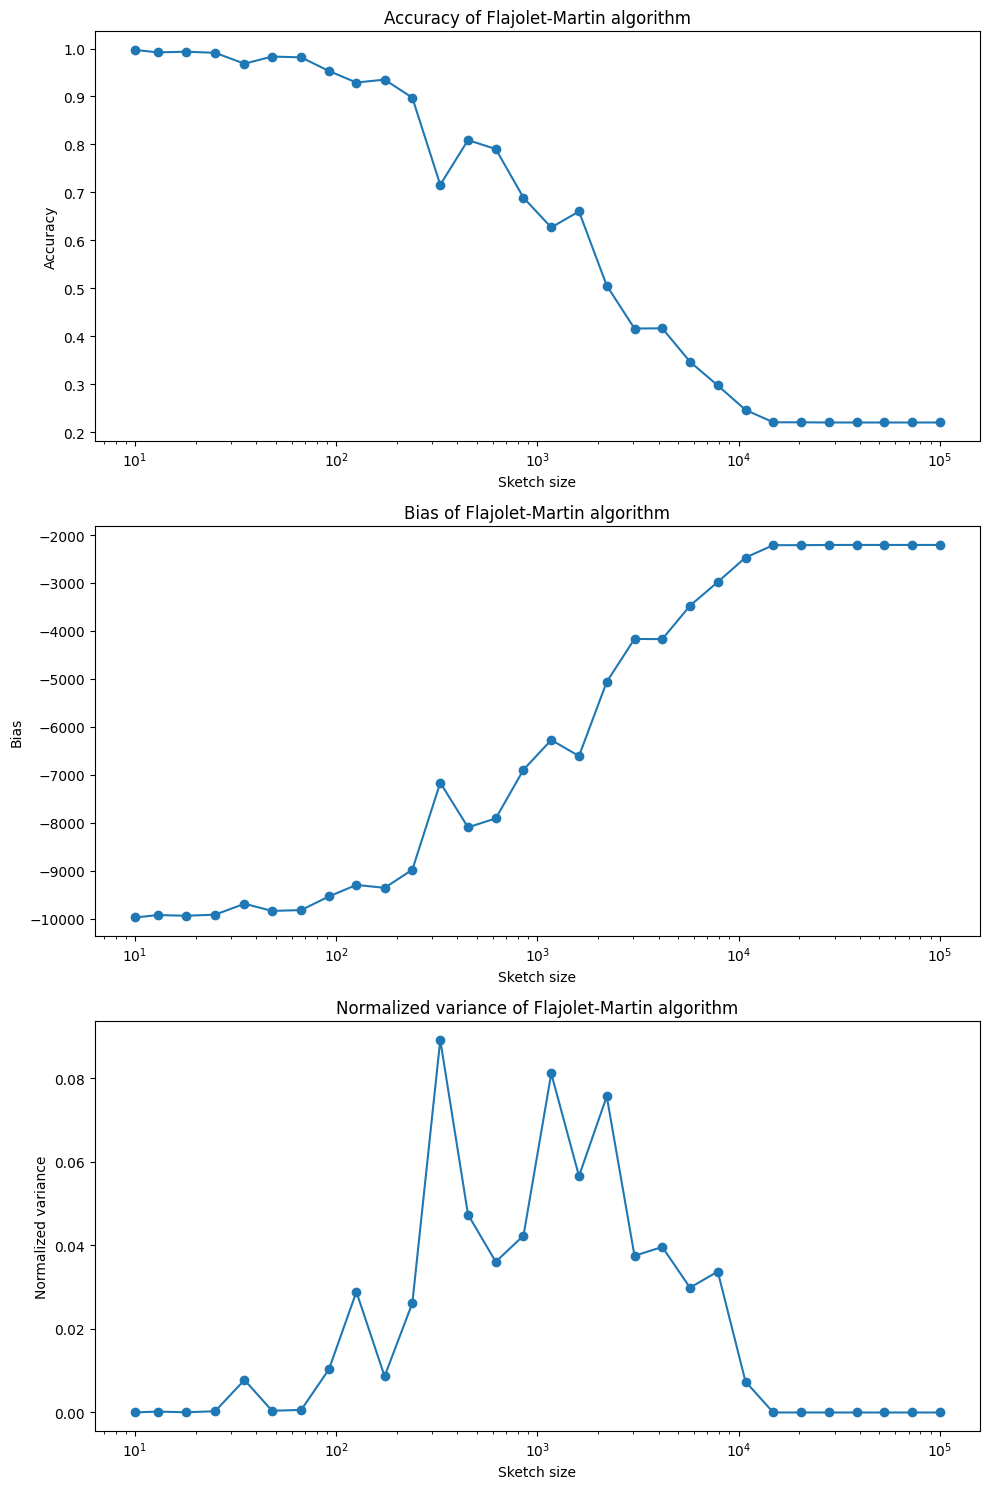

In [ ]:
import matplotlib.pyplot as plt

true_unique = len(np.unique(stream))

accuracies = np.array([np.mean([abs(est - true_unique) / true_unique for est in results[size]])
                          for size in sketch_sizes])

variances = np.array([np.var([abs(est - true_unique) / true_unique for est in results[size]])
                            for size in sketch_sizes])

biases = np.array([np.mean([est - true_unique for est in results[size]])
                            for size in sketch_sizes])

# Create a figure and axis
fig, axs = plt.subplots(3, 1, figsize=(10, 15))

# Plot the accuracy
axs[0].plot(sketch_sizes, accuracies, marker='o')
axs[0].set_xscale('log')
axs[0].set_xlabel("Sketch size")
axs[0].set_ylabel("Accuracy")
axs[0].set_title("Accuracy of Flajolet-Martin algorithm")

# Plot the bias
axs[1].plot(sketch_sizes, biases, marker='o')
axs[1].set_xscale('log')
axs[1].set_xlabel("Sketch size")
axs[1].set_ylabel("Bias")
axs[1].set_title("Bias of Flajolet-Martin algorithm")

# Plot the normalized variance
axs[2].plot(sketch_sizes, variances, marker='o')
axs[2].set_xscale('log')
axs[2].set_xlabel("Sketch size")
axs[2].set_ylabel("Normalized variance")
axs[2].set_title("Normalized variance of Flajolet-Martin algorithm")

plt.tight_layout()
plt.show()